# Test the HALO Downstreaming Pipelines

## Load the library

In [1]:
from typing import Dict, Iterable, Optional
import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
from complementary_models import torch_infer_nonsta_dir
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


In [2]:
adata_mvi = HALOVI.setup_dataset(multiomic="halo/E18_mouse_Brain/multiomic.h5ad", rna_ann="halo/E18_mouse_Brain/RNA/metadata.tsv")
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [3]:
adata_mvi.var

,gene_ids,feature_types,modality,n_cells
Xkr4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283
Gm1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443
Gm19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683
Rp1,ENSMUSG00000025900,Gene Expression,Gene Expression,36
Mrpl15,ENSMUSG00000033845,Gene Expression,Gene Expression,971
...,...,...,...,...
GL456216.1:37994-39286,GL456216.1:37994-39286,Peaks,Peaks,266
GL456216.1:40534-41810,GL456216.1:40534-41810,Peaks,Peaks,139
GL456216.1:49045-49376,GL456216.1:49045-49376,Peaks,Peaks,35
JH584292.1:12573-14868,JH584292.1:12573-14868,Peaks,Peaks,231


## Load pretrained model

In [38]:
model = model.load("model_neural_BM_mouse_causal_0065_softmax", adata_mvi)

INFO     File model_neural_BM_mouse_causal_0065_softmax/model.pt already downloaded          
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [39]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [5]:
latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep_t, latent_expr_indep_t, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep_t, latent_atac_indep_t, times)
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.04534597369340188 and score4 0.05988556228578844


tensor(-0.0145, device='cuda:0', dtype=torch.float64)

In [6]:
latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_dep_t, latent_expr_dep_t, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_dep_t, latent_atac_dep_t, times)
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

/tmp/ipykernel_18338/2827984348.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


score3 0.0644952651666028 and score4 0.06476418166583295


tensor(-0.0003, device='cuda:0', dtype=torch.float64)

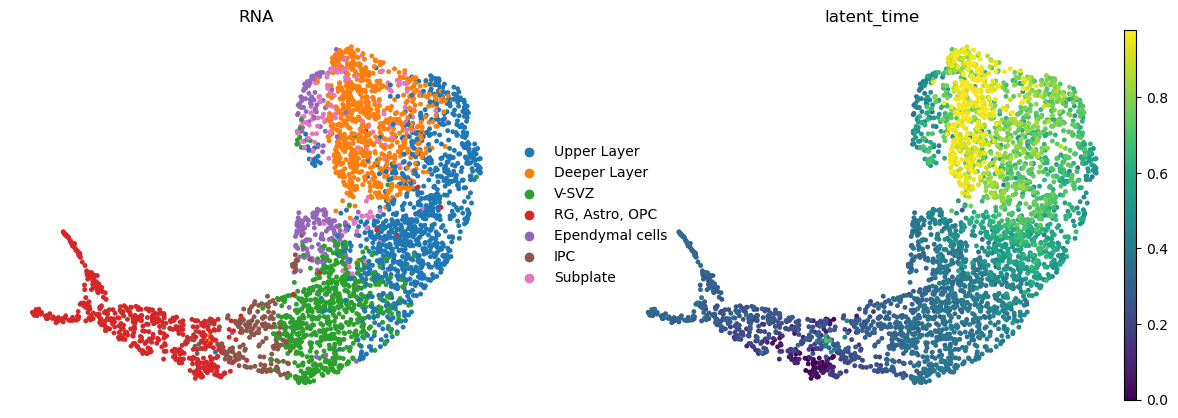

In [44]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

In [4]:
### store the latent representations, latent denoms and library size of the autoencoder models
atac_denoms, rna_denoms = model.get_atac_expr_denoms()

In [9]:
from complementary_models import split_rna,split_atac
rna_data = split_rna(adata_mvi=adata_mvi)
atac_data = split_atac(adata_mvi)

In [14]:
rna_data.obs["softmax_denom"] = rna_denoms
atac_data.obs["softmax_denom"] = atac_denoms

In [15]:
atac_data.obs

,celltype,batch_id,modality,latent_time,_scvi_batch,_scvi_labels,softmax_denom
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired,0.604954,0,0,145137.421875
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired,0.281341,0,0,150304.375000
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired,0.851495,0,0,132862.343750
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired,0.982605,0,0,136930.281250
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired,0.549869,0,0,140730.015625
...,...,...,...,...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired,0.454965,0,0,139211.078125
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired,0.598991,0,0,134930.093750
TTTGTGTTCAATGACC-1_paired,IPC,1,paired,0.291581,0,0,157035.312500
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired,0.776289,0,0,144882.781250


## Get the coupled and decoupled Genes

### get the loading matrix

In [3]:
rnaloading = model.get_rna_loading()
rnaloading = rnaloading.T

[Text(0.5, 14.722222222222216, 'genes')]

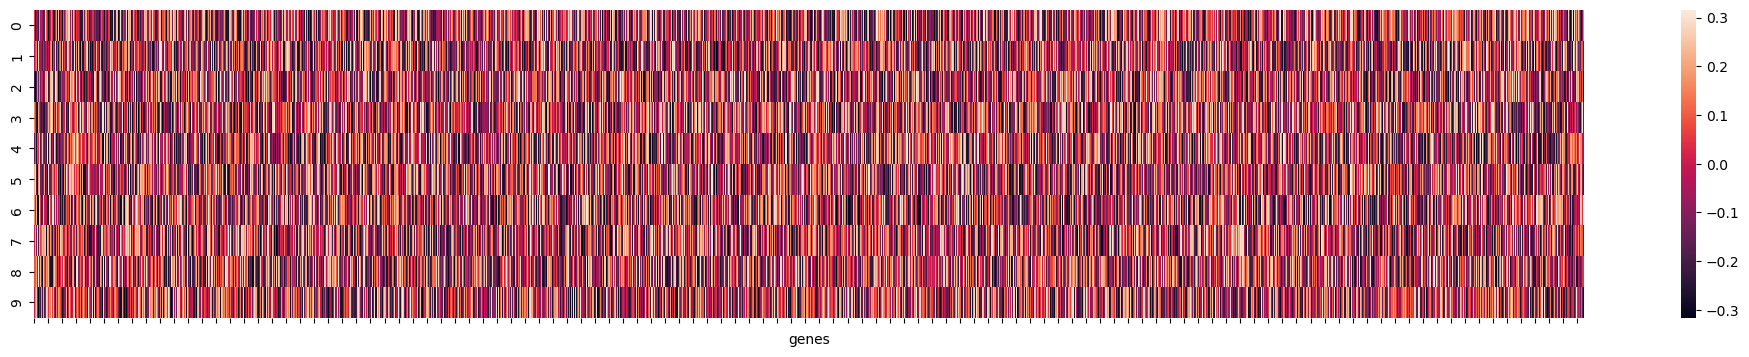

In [4]:
plt.figure(figsize=(25,4))
hm = sns.heatmap(rnaloading)
hm.set(xticklabels=[]) 
hm.set(xlabel="genes")

In [10]:
## get RNA data
from complementary_models import split_rna
rna_data = split_rna(adata_mvi=adata_mvi)


### get the highly variable genes

In [11]:
sc.pp.filter_genes(rna_data, min_cells=15)
rna_data.raw = rna_data
## normlaize the read depths of each cell, then logarithmize the data:
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)
# Calculate highly variable genes, but with a less stringent dispersion threshold. This set of genes will be our “exogenous” genes:
sc.pp.highly_variable_genes(rna_data, min_disp = 0.2, n_top_genes=None)
rna_data.var['exog'] = rna_data.var.highly_variable.copy()
# Finally, calculate the “endogenous” geneset by intersecting the exogenous set with genes with a higher dispersion threshold:
rna_data.var['endog'] = rna_data.var.exog & (rna_data.var.dispersions_norm > 0.7)
# Restore the raw counts to the counts layer.
rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()


In [12]:
## add the latent features of model
rna_data.obsm["X_topic_compositions"] = latent_expr

### get the decoupled score and couple scores from the loading matrix

In [13]:
couplescore, decouplescore = model.get_rna_decoupled_score(rnaloading, rnadata=rna_data)
rna_data.var["decouple_score"] = decouplescore
rna_data.var["couple_socre"] = couplescore
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
Xkr4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False,0.431871,1.845618
Gm1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443,False,0.124291,0.168296,-0.830691,False,False,4.228517,0.709708
Gm19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683,False,0.228712,0.461415,-0.033439,False,False,3.119030,1.848980
Rp1,ENSMUSG00000025900,Gene Expression,Gene Expression,36,True,0.020071,0.943040,1.276528,True,True,0.961448,0.495212
Mrpl15,ENSMUSG00000033845,Gene Expression,Gene Expression,971,False,0.319294,0.355616,-0.493027,False,False,3.961977,6.937976
...,...,...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,Gene Expression,695,False,0.239101,0.455474,-0.049597,False,False,1.243082,3.369823
Vamp7,ENSMUSG00000051412,Gene Expression,Gene Expression,755,False,0.239121,0.339640,-0.364654,False,False,7.689047,6.110465
Tmlhe,ENSMUSG00000079834,Gene Expression,Gene Expression,559,True,0.223619,0.611113,0.373723,True,False,2.122510,3.395123
4933409K07Rik,ENSMUSG00000095552,Gene Expression,Gene Expression,52,False,0.012195,-0.123272,-1.623724,False,False,0.561330,4.516055


In [40]:
rna_data.var.sort_values("decouple_score", ascending=False).head(10)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
Mcfd2,ENSMUSG00000024150,Gene Expression,Gene Expression,315,False,0.092301,0.225188,-0.675949,False,False,8.534699,2.442541
Fsip1,ENSMUSG00000027344,Gene Expression,Gene Expression,165,False,0.056479,0.447691,-0.070767,False,False,8.468770,0.285056
Endov,ENSMUSG00000039850,Gene Expression,Gene Expression,516,False,0.162731,0.452221,-0.058444,False,False,8.425608,4.702056
Cpa2,ENSMUSG00000071553,Gene Expression,Gene Expression,44,False,0.013856,0.278495,-0.530960,False,False,8.372500,0.645878
Sf3b3,ENSMUSG00000033732,Gene Expression,Gene Expression,1835,False,0.658379,0.425014,-0.500215,False,False,8.218758,5.087647
Ccdc22,ENSMUSG00000031143,Gene Expression,Gene Expression,312,False,0.086439,0.158195,-0.858164,False,False,8.133165,1.297268
Slc7a8,ENSMUSG00000022180,Gene Expression,Gene Expression,474,False,0.156170,0.479141,0.014774,False,False,7.982368,0.135091
E130102H24Rik,ENSMUSG00000086782,Gene Expression,Gene Expression,520,False,0.161219,0.284115,-0.515675,False,False,7.943653,1.104510
Taf3,ENSMUSG00000025782,Gene Expression,Gene Expression,1338,False,0.506369,0.589980,0.104246,False,False,7.939208,4.539752
Elp4,ENSMUSG00000027167,Gene Expression,Gene Expression,1551,True,0.675890,0.991384,0.733007,True,True,7.848054,0.986449


In [42]:
## save the data
rna_data.write_h5ad("data/datasets/mouse_brain_rna_interim.h5ad")

In [5]:
## split the atac data
from complementary_models import split_atac, reindex_atac

atac_data = split_atac(adata_mvi=adata_mvi)
atac_data = reindex_atac(atac_data)

In [6]:
atac_data.var

,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52
...,...,...,...,...
123879,GL456216.1,37994,39286,266
123880,GL456216.1,40534,41810,139
123881,GL456216.1,49045,49376,35


In [7]:
atac_data.write_h5ad("data/datasets/mouse_brain_atac_interim.h5ad")

### Merge the atac data with the anotation


In [38]:
[e for e in rna_data.var.index if "xrcc" in str(e).lower()]

['Xrcc5', 'Xrcc2', 'Xrcc1', 'Xrcc3', 'Xrcc4', 'Xrcc6']

In [39]:
rna_data.var.loc["Xrcc4"]

gene_ids            ENSMUSG00000021615
feature_types          Gene Expression
modality               Gene Expression
n_cells                           1193
highly_variable                   True
means                         0.533738
dispersions                   0.957531
dispersions_norm              1.040948
exog                              True
endog                             True
decouple_score                3.188043
couple_socre                  3.137704
Name: Xrcc4, dtype: object

In [41]:
rna_data.var[rna_data.var.highly_variable==True].sort_values("couple_socre", ascending=False).head(10)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
Snx8,ENSMUSG00000029560,Gene Expression,Gene Expression,158,True,0.066791,0.680346,0.562029,True,False,1.292411,8.018675
Top2a,ENSMUSG00000020914,Gene Expression,Gene Expression,440,True,0.674346,2.725963,4.509905,True,True,0.905042,7.716978
Nemp1,ENSMUSG00000040195,Gene Expression,Gene Expression,478,True,0.178601,0.669797,0.533338,True,False,0.166596,7.690342
Pcdh18,ENSMUSG00000037892,Gene Expression,Gene Expression,260,True,0.099357,0.612424,0.377289,True,False,1.467904,7.629585
Gm15155,ENSMUSG00000055109,Gene Expression,Gene Expression,96,True,0.051634,1.120093,1.758094,True,True,3.766707,7.612002
Tank,ENSMUSG00000064289,Gene Expression,Gene Expression,806,True,0.317087,0.678086,0.328785,True,False,2.529274,7.536418
Ripk1,ENSMUSG00000021408,Gene Expression,Gene Expression,224,True,0.083013,0.593771,0.326556,True,False,0.495087,7.509144
Atf6,ENSMUSG00000026663,Gene Expression,Gene Expression,1234,True,0.461483,0.636022,0.221585,True,False,0.915401,7.501701
Acvr2a,ENSMUSG00000052155,Gene Expression,Gene Expression,2064,True,0.961082,1.074425,0.560879,True,False,0.743466,7.200153
6030443J06Rik,ENSMUSG00000097207,Gene Expression,Gene Expression,318,True,0.132092,0.756852,0.770118,True,True,2.529289,7.094105


## RNA enrichment analysis

### load RNA data first

In [5]:
rna_data = sc.read_h5ad("data/datasets/mouse_brain_rna_interim.h5ad")
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
Xkr4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False,0.432015,1.846041
Gm1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443,False,0.124291,0.168296,-0.830691,False,False,4.229676,0.709885
Gm19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683,False,0.228712,0.461415,-0.033439,False,False,3.119903,1.849536
Rp1,ENSMUSG00000025900,Gene Expression,Gene Expression,36,True,0.020071,0.943040,1.276528,True,True,0.961691,0.495256
Mrpl15,ENSMUSG00000033845,Gene Expression,Gene Expression,971,False,0.319294,0.355616,-0.493027,False,False,3.963007,6.939843
...,...,...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,Gene Expression,695,False,0.239101,0.455474,-0.049597,False,False,1.243497,3.370726
Vamp7,ENSMUSG00000051412,Gene Expression,Gene Expression,755,False,0.239121,0.339640,-0.364654,False,False,7.691081,6.112227
Tmlhe,ENSMUSG00000079834,Gene Expression,Gene Expression,559,True,0.223619,0.611113,0.373723,True,False,2.123045,3.396068
4933409K07Rik,ENSMUSG00000095552,Gene Expression,Gene Expression,52,False,0.012195,-0.123272,-1.623724,False,False,0.561484,4.517371


In [6]:
## get top genes for each latent factors

topgenes_latent_1 = model.get_top_genes(300, loadingmatrix=rnaloading, latent_index=1, rnadata =rna_data,colname="index") # gene names are saved as the adata.var index

In [11]:
## get post gene_list
from tools.enrichment import get_post_genelist, fetch_genelist_enrichments

post_genelist = get_post_genelist(topgenes_latent_1)
results = fetch_genelist_enrichments(post_genelist)

In [14]:
results["results"].keys()

dict_keys(['WikiPathways_2019_Human', 'WikiPathways_2019_Mouse', 'KEGG_2019_Human', 'KEGG_2019_Mouse', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018', 'GO_Biological_Process_2018', 'BioPlanet_2019'])

In [10]:
post_genelist

{'list_id': 62542378, 'results': {}}

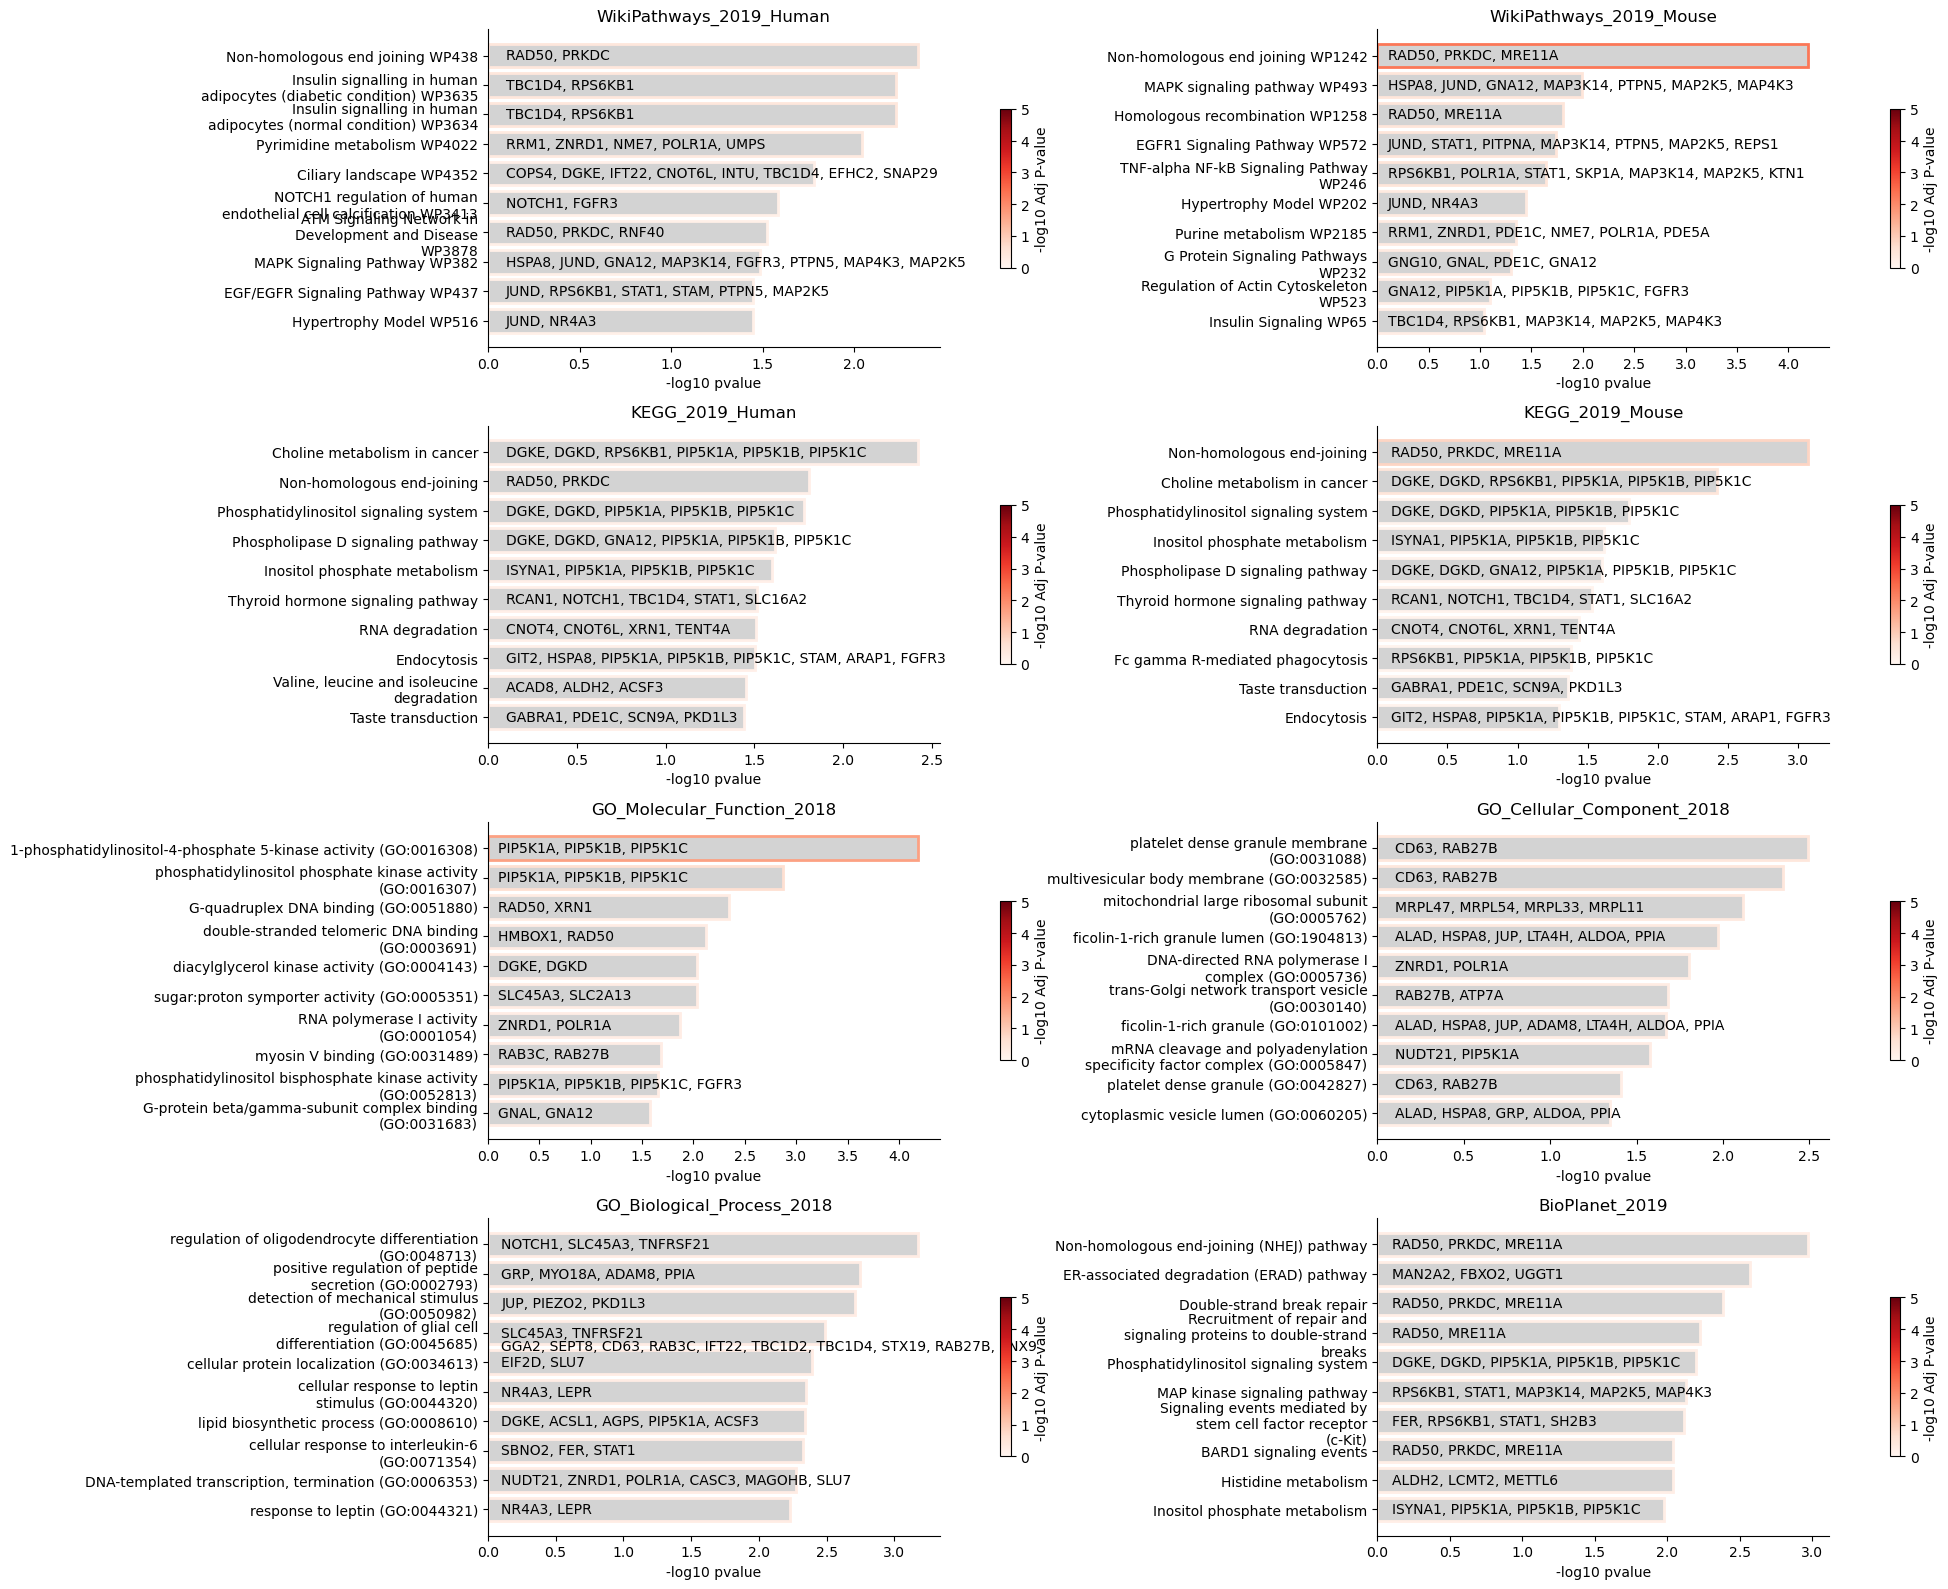

In [15]:
## plot the enrichment results
from tools.enrichment import plot_enrichments_genesets
plot_enrichments_genesets(results)

## plot the top decouple genes


In [25]:
topgenes_decouple = rna_data.var.sort_values("decouple_score", ascending=False).index[:700]

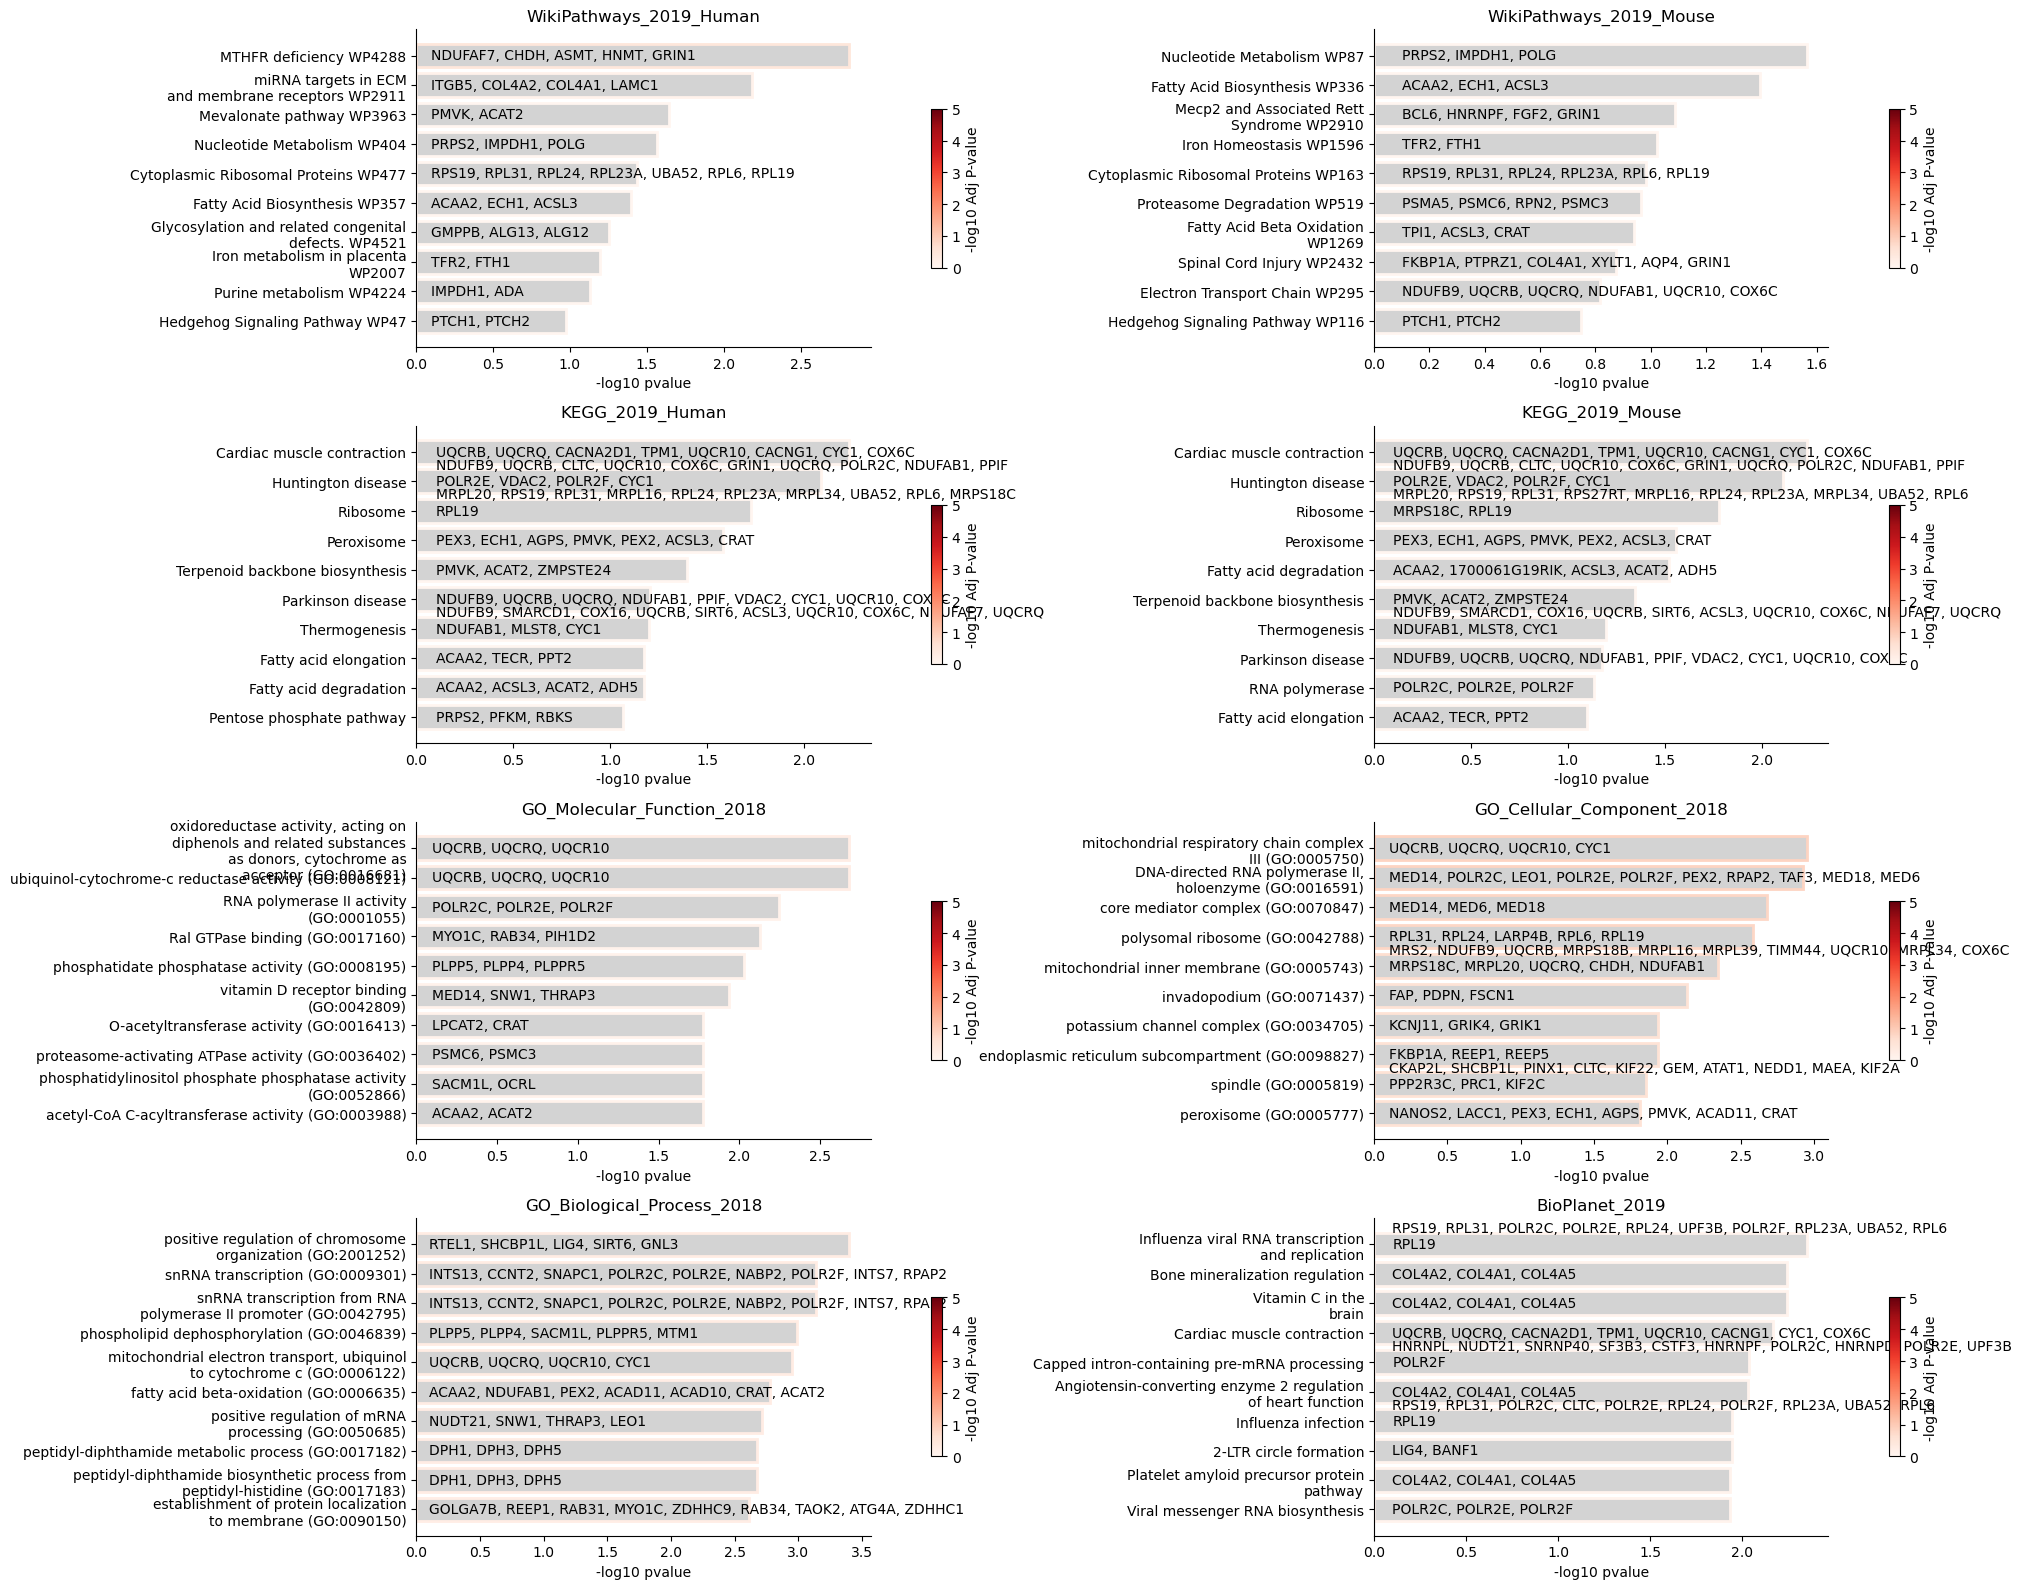

In [26]:
post_genelist = get_post_genelist(topgenes_decouple)
results = fetch_genelist_enrichments(post_genelist)
plot_enrichments_genesets(results)

In [47]:
# rna_data.obsm["X_umap"] = np.stack([latent_expr, latent_acc], axis=2)
rna_data.obsm["X_umap"] = latent_expr
sc.pp.neighbors(rna_data, use_rep = 'X_umap', metric = 'manhattan',
               n_neighbors = 20)

<AxesSubplot:title={'center':'latent_time'}, xlabel='UMAP1', ylabel='UMAP2'>

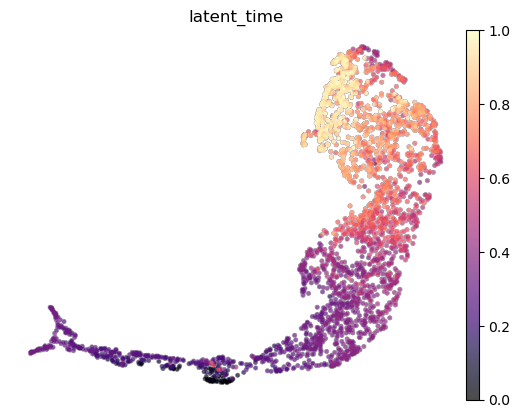

In [55]:
## Streaming graph plotting

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=450, frameon = False, legend_fontsize=12
)

# sc.pl.umap(rna_data, color = 'latent_time', show = False,
#            **umap_kwargs, color_map = 'magma')

## finetune the min_dist 
sc.tl.umap(rna_data,min_dist =0.1)

sc.pl.umap(rna_data, color = 'latent_time', **umap_kwargs, show = False, color_map = 'magma')           